# Task
Сделать базовый вариант бинарной классификации, от которого можно отталкиваться в дальнейшем

# Import modules

In [428]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

import Handlers as hd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [429]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

from sklearn.model_selection import train_test_split # сплитование выборки
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder, BinaryEncoder

from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

from sklearn import set_config
# set_config(transform_output='pandas')

%matplotlib inline
plt.style.use('seaborn-darkgrid')
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10, 8)

# Load Data

In [430]:
data = pd.read_parquet('..\ETH-Full-1H.parquet')

In [431]:
df = data.copy()

In [432]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49337 entries, 2017-09-01 00:00:00 to 2023-04-23 23:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    49337 non-null  float64
 1   High    49337 non-null  float64
 2   Low     49337 non-null  float64
 3   Close   49337 non-null  float64
 4   Volume  49337 non-null  float64
 5   Trades  49337 non-null  int32  
dtypes: float64(5), int32(1)
memory usage: 2.4 MB


In [433]:
df

,Open,High,Low,Close,Volume,Trades
Datetime,,,,,,
2017-09-01 00:00:00,384.79,388.74,384.79,388.74,162.97779,131
2017-09-01 01:00:00,388.69,394.06,387.53,391.37,248.72949,262
2017-09-01 02:00:00,392.88,394.39,389.46,390.88,198.82856,225
2017-09-01 03:00:00,391.70,393.13,390.86,390.86,141.56114,138
2017-09-01 04:00:00,392.65,394.27,387.64,390.33,135.65894,128
...,...,...,...,...,...,...
2023-04-23 19:00:00,1846.76,1852.35,1844.92,1846.49,16550.18290,21648
2023-04-23 20:00:00,1846.49,1852.30,1838.03,1848.89,13113.47550,19445
2023-04-23 21:00:00,1848.88,1859.32,1847.59,1854.66,7855.61330,13824


# Base Visualization

In [434]:
# # If need to plot not all data
# # df_to_plot = df[df.index >= '2018-01-01']
# df_to_plot = df

# # Create a 2-row, 1-column subplot grid
# fig, ax = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

# # Convert series to numpy
# ind = df_to_plot.index.to_numpy()
# _0 = df_to_plot['Close'].to_numpy()
# _1 = df_to_plot['Volume'].to_numpy()
# _2 = df_to_plot['Trades'].to_numpy()

# ax[0].plot(ind, _0, linewidth=1)
# ax[0].set_title('Close')

# ax[1].fill_between(ind, _1, step='pre')
# ax[1].set_title('Volume')

# ax[2].fill_between(ind, _2, step='pre')
# ax[2].set_title('Trades')

# # Set the x-axis label for the entire figure
# plt.xlabel('Date')

# # Adjust the layout and show the plot
# plt.tight_layout()
# plt.show()

В 17 году совсем маленькие объемы, подрежу данные. Не буду брать то что до 18 года

In [435]:
df = df[df.index >= '2018-01-01'].copy()

### Провека всех признаков исходного ряда на стационарность

In [436]:
# for col_name, col_data in df.items():
#     print("Column Name : ", col_name)
#     hd.adf(col_data.values)
#     print()

# Feature Enginiring
Логарифмирую все признаки

In [437]:
cols = df.columns
for col in cols:
    df[col + '_log'] = np.log(df[col])

df.drop(columns=cols, inplace=True) # удаляю все старые признаки

In [438]:
df

,Open_log,High_log,Low_log,Close_log,Volume_log,Trades_log
Datetime,,,,,,
2018-01-01 00:00:00,6.597159,6.599217,6.579293,6.589779,7.652499,8.043663
2018-01-01 01:00:00,6.588940,6.595781,6.574797,6.576428,7.743257,7.963808
2018-01-01 02:00:00,6.576010,6.587206,6.575898,6.584860,7.680849,7.991931
2018-01-01 03:00:00,6.584722,6.603930,6.582994,6.599190,7.678282,8.201660
2018-01-01 04:00:00,6.599857,6.613357,6.593058,6.613143,7.755912,8.163941
...,...,...,...,...,...,...
2023-04-23 19:00:00,7.521188,7.524210,7.520191,7.521042,9.714152,9.982668
2023-04-23 20:00:00,7.521042,7.524183,7.516450,7.522341,9.481396,9.875345
2023-04-23 21:00:00,7.522335,7.527966,7.521637,7.525457,8.968984,9.534161


Тени от открытия бара на лог шкале

In [439]:
df['Low_Shad_log'] = df['Open_log'] - df['Low_log']
df['High_Shad_log'] = df['High_log'] - df['Open_log']

Прирост за бар на лог шкале

Прирост и тени от открытия бара, т.к. в истории есть пропуски по много часов и они могут давать сильные искажения, вылеты для таргетов

Фактически это аналог first difference

In [440]:
df['Log_Return'] = df['Close_log'] - df['Open_log']

# Create Target Category Feature 
Создаю целевой признак

Это фактически очередные гиперпараметры.

Я могу задавать уровень риска в лог величинах - risk_level

и коэффициент доходность/риск в виде множителя - risk_factor

Т.е. текущий случай это:
* risk_level = 0.0025
* risk_factor = 4

In [441]:
risk_level = 0.0025
profit_factor = 4
profit_level = risk_level * profit_factor
TARGET = 'Long'

In [461]:
zero_mo = hd.profit_margin_for_zero_mo(risk_level, profit_factor)
print('Метрика Precision должна быть выше:', zero_mo)

Метрика Precision должна быть выше: 0.2


По данным переменным можно создавать сетку для поиска рабочих вариантов

In [443]:
df[TARGET] = np.where((df['High_Shad_log'] >= profit_level) & (df['Low_Shad_log'] <= risk_level), 1, 0)

In [475]:
class_df = pd.DataFrame({'%': (df[TARGET].value_counts(True) * 100).round(2), 'Count': df[TARGET].value_counts()})
class_df.index.name = 'Class'
class_df.sort_index(ascending=False, inplace=True)
class_df
    

,%,Count
Class,,
1,9.16,4252
0,90.84,42164


# Feature Engineering
* Преобразую исходные данные
* Получаю новые признаки. 
* Удаляю ненужные.
* Обогощаю данные.

* Объемы и сделки:
Можно считать средний объем сделки. 
- AvrTrade = Volume / Trades
- Объем в долларах, т.е. нормированный объем VolUSD = Volume * Close
- Объем на единицу диапазона.

### Базовая модель - оставляю в качестве признака только Log_Return и целевой признак

In [446]:
df = df[['Log_Return', TARGET]].copy()
df

,Log_Return,Long
Datetime,,
2018-01-01 00:00:00,-0.007380,0
2018-01-01 01:00:00,-0.012512,0
2018-01-01 02:00:00,0.008851,1
2018-01-01 03:00:00,0.014468,1
2018-01-01 04:00:00,0.013286,0
...,...,...
2023-04-23 19:00:00,-0.000146,0
2023-04-23 20:00:00,0.001299,0
2023-04-23 21:00:00,0.003121,0


# Outliers
Обработка выбросов. Пробовать прорядить выборку удалением записей по методу:
- 3х сигм
- методу Тьюки
- Isolation Forest
- Local Outlier Factor
- Minimun Covariance Determinant

Но обработку надо делать уже после разделения выборки на train/test

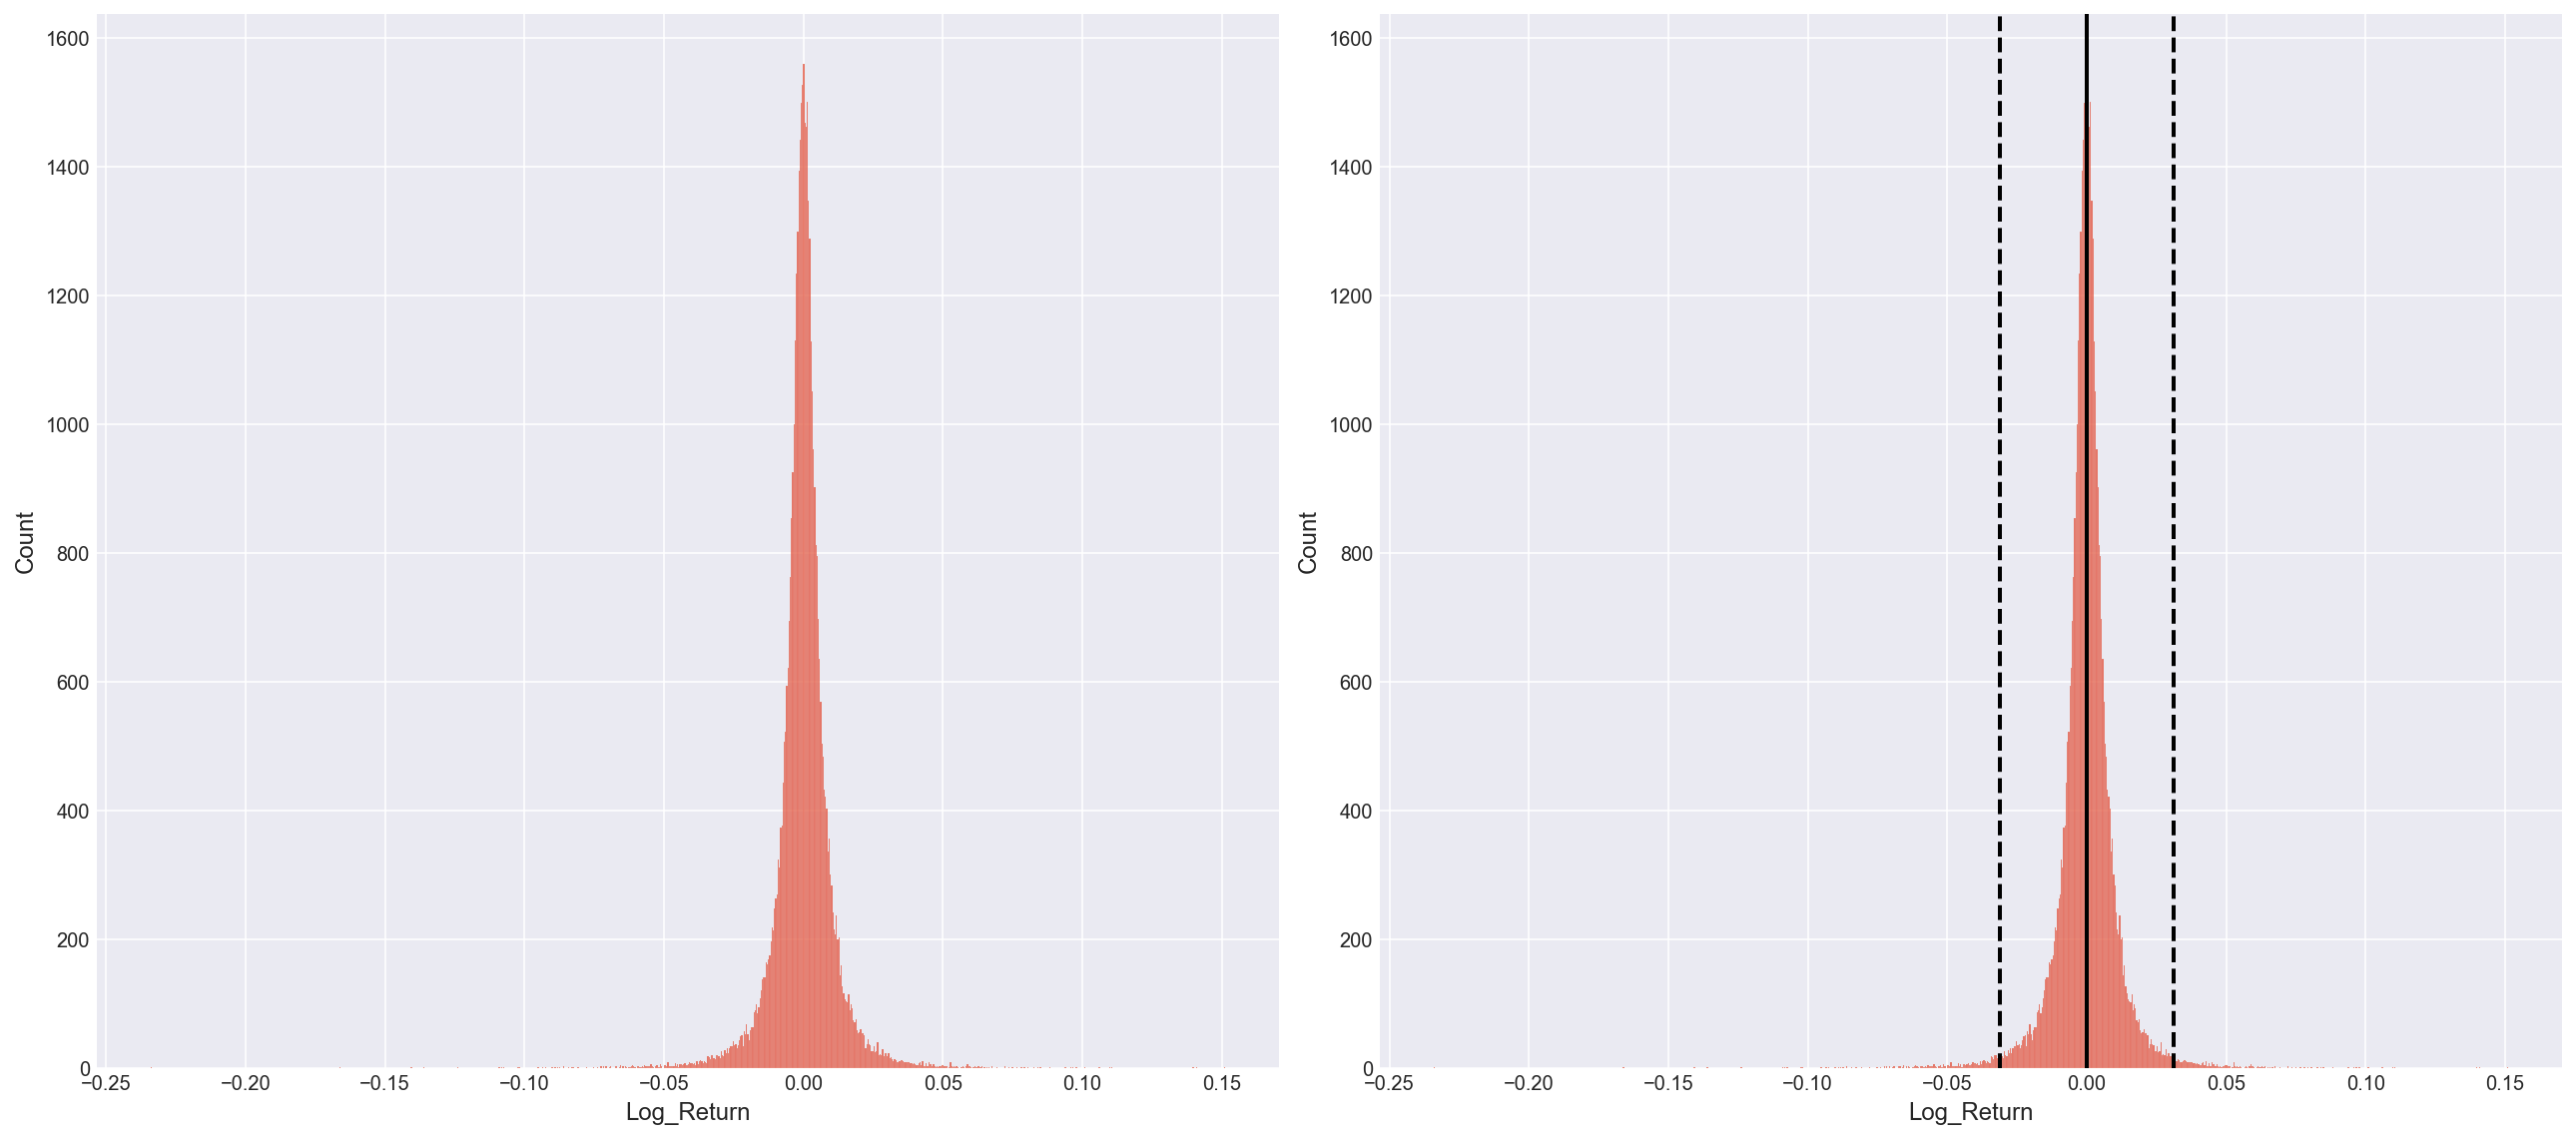

In [447]:
hd.plot_outliers_z_score(df, 'Log_Return', log_scale=False) # log_scale=False т.к. цены были изначально прогалорифмированы и затем еще и разница посчитана

Распределение выглядит максимально равномерно. 
Позже, на последующих итерациях можно думать о том, что бы обрезать хвосты и посмотреть как это отразится на результатах модели.

# Transform TimeSeries to Dataset for Supervised Learning
Тут определяется глубина последовательности данных, которая будет использоваться для построения прогноза T. Временное окно в прошлое.

Т это так же гиперпараметр, его так же нужно будет искать по сетке.

# Create dataset
## Define features and targets

In [448]:
features = df.drop(columns=TARGET).values
targets = df[TARGET].values

## Build Data
Define data dimension

In [449]:
T = 12 # len of sequence. Num of time steps to look at to make prediction on next step
D = features.shape[1] # Num of columns in input data. Features number.
N = features.shape[0] - T # Num of samples in dataset

Create $X$, $y$

In [450]:
X = np.zeros((N, T, D))
y = np.zeros(N)

for t in range(N):
  X[t, :, :] = features[t:t+T]
  y[t] = targets[t+T]

X = X.reshape(-1, T) # Для классических моделей ML 3D матрицу нужно распаковать в 2D. В ANN нужно отпралять 3D, без распаковки.

In [451]:
print('X.shape:', X.shape, 'y.shape:', y.shape)

X.shape: (46404, 12) y.shape: (46404,)


# Split Data
Разбиение с стратифиацией

In [452]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1, test_size=0.2)

После разбиения сохраняется распределение классов целевого признака

In [453]:
pd.Series(y_train).value_counts(True)

0.0    0.90844
1.0    0.09156
Name: proportion, dtype: float64

In [454]:
pd.Series(y_test).value_counts(True)

0.0    0.908415
1.0    0.091585
Name: proportion, dtype: float64

# Scaling Data
Нужно скалировать признаки, приводить их к одному масштабу. Путем перебора выбирать лучший скалер.

In [455]:
# scaler = StandardScaler()

# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Create Model

In [456]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [457]:
hd.print_classification_metrics(y_train, y_train_pred, y_test, y_test_pred)

*** TRAIN ***
Accuracy: 0.530
Precision: 0.104
Recall: 0.541
F1: 0.174

*** TEST ***
Accuracy: 0.529
Precision: 0.101
Recall: 0.526
F1: 0.170


In [458]:
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

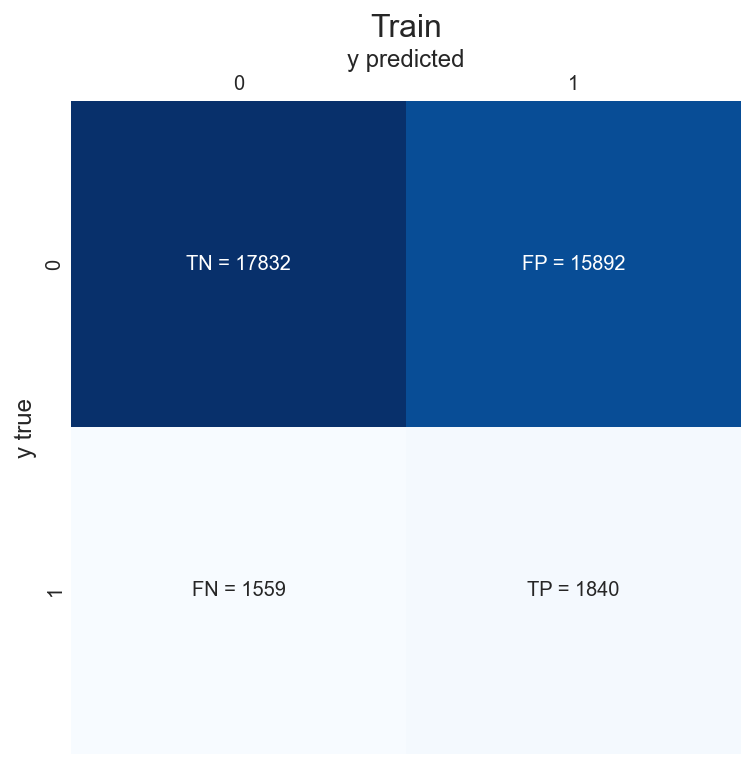

In [459]:
hd.plot_confusion_matrix(cm_train, 'Train')

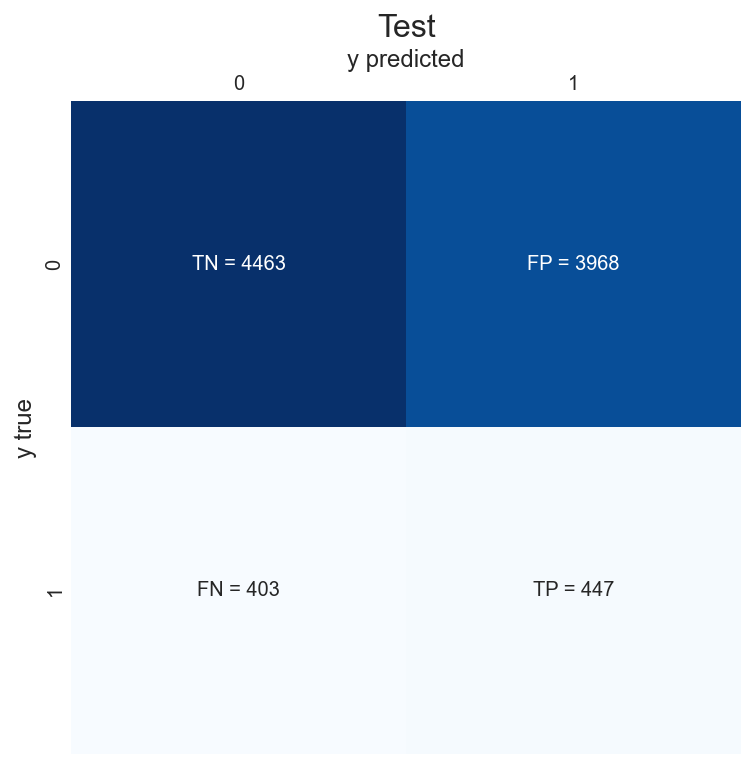

In [460]:
hd.plot_confusion_matrix(cm_test, 'Test')

In [480]:
pd.Series(y_test).value_counts()

0.0    8431
1.0     850
Name: count, dtype: int64

In [481]:
pd.Series(y_test_pred).value_counts()

0.0    5517
1.0    3764
Name: count, dtype: int64

Видно, что я очень много предсказываю класс 1, надо сильно меньше. Нужно на Precision фокусироваться.

Вот такая базовая модель.

Precision 0.101. Т.е. точность всего 10%.

*** TRAIN ***
Accuracy: 0.531
Precision: 0.104
Recall: 0.540
F1: 0.174

*** TEST ***
Accuracy: 0.528
Precision: 0.101
Recall: 0.524
F1: 0.169

# Случайный лес
подбор параметров вручную

In [ ]:
rf = RandomForestClassifier(n_estimators=500, max_depth=5, min_samples_leaf=5, class_weight='balanced')
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
hd.print_classification_metrics(y_train, y_train_pred, y_test, y_test_pred)

Моя задача это что бы Precision был больше нулевой точки матожидания.
Как свою метрику можно использовать разницу Precision-zero_mo. Чем она ближе к нулю, тем лучше. В идеале она должна быть положительной.

Так же мне нужно переводить метки в реальный подсчет результатов сделок, то что я начинал делать в ноутбуке Calulate_Result.
Ведь даже если по метрикам я промазал и был FP прогноз, это еще не значит что сделка была бы убыточной.

Нужно брать предсказанные метки, как-то соединять их с датафреймом и считать результаты сделок 

### Что я могу делать дальше:
- Добавление признаков, сейча используется лишь Log_Return. Добавляю ценовые признаки, для начала размеры теней, которые исопльзовались для генерации целевого признака
- Признак диапазона бара, размера тела в % к диапазону.
- Добавление признаков сгенерированных из даты.
- Добавление признаков сгенерированных из торгового объема.
- генерация целевого признака по сетке параметров risk_level = 0.0025, profit_factor = 4. Изучение значений Precision, zero_mo и их разницы
- обход основных моделей ML для классификации
- Из вектора предсказанных меток получение результатов торговли, надо как-то метки совмещать опять с исходным датафреймом. где бы можно было бы считать результаты торговли